## Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

## Import Datasets

In [2]:
df_takehome_user_engagement = pd.read_csv('../takehome_user_engagement.csv')
df_takehome_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [3]:
df_takehome_users = pd.read_csv('../takehome_users.csv', encoding = 'ISO-8859-1')
df_takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


## Clean up datasets for analysis

In [4]:
df_takehome_users.last_session_creation_time = \
    pd.to_datetime(df_takehome_users.last_session_creation_time, unit='s')
df_takehome_users.creation_time = \
    pd.to_datetime(df_takehome_users.creation_time)

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, __identify which factors predict future user adoption.__

In [5]:
df_takehome_user_engagement['date'] = pd.to_datetime(df_takehome_user_engagement.time_stamp).dt.date

# Get list of users that are considered "adopted users"
adopted_user_id = sorted(pd.DataFrame(df_takehome_user_engagement.user_id.value_counts()).\
                    query('user_id >= 3').index.to_list())

In [6]:
# Get subset of df_takehome_users that are associated with "adopted users"
df_takehome_users['is_adopted_user'] = (df_takehome_users['object_id'].isin(adopted_user_id)).astype(int)
df_takehome_users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,0


In [7]:
engagement_counts = pd.DataFrame(df_takehome_user_engagement.user_id.value_counts().sort_index())

In [8]:
df_adopted_users = df_takehome_users.merge(engagement_counts, how='left', 
    left_on='object_id', right_index=True).rename(columns={'user_id':'engagement_count'})

In [9]:
df_adopted_users['ORG_INVITE'] = (df_adopted_users.creation_source == "ORG_INVITE").astype(int)
df_adopted_users['SIGNUP'] = (df_adopted_users.creation_source == "SIGNUP").astype(int)
df_adopted_users['GUEST_INVITE'] = (df_adopted_users.creation_source == "GUEST_INVITE").astype(int)
df_adopted_users['SIGNUP_GOOGLE_AUTH'] = (df_adopted_users.creation_source == "SIGNUP_GOOGLE_AUTH").astype(int)
df_adopted_users['PERSONAL_PROJECTS'] = (df_adopted_users.creation_source == "PERSONAL_PROJECTS").astype(int)

In [10]:
df_adopted_users.creation_time = (df_adopted_users.creation_time
                                  - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [11]:
df_adopted_users.last_session_creation_time = (df_adopted_users.last_session_creation_time 
                                               - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [12]:
df_adopted_users_logreg = df_adopted_users.dropna().reset_index()

## Use Logistic Regression to predict "adopted users"

In [13]:
featurenames = ['creation_time', 'last_session_creation_time', 'opted_in_to_mailing_list',
                'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
                'engagement_count', 'ORG_INVITE', 'SIGNUP', 'GUEST_INVITE',
                'SIGNUP_GOOGLE_AUTH', 'PERSONAL_PROJECTS']
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           df_adopted_users_logreg, featurenames,
                                                           'is_adopted_user',1)

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.97
Accuracy on test data:     0.97


Using Logistic Regression to predict whether a user will be "adopted" seemed to be a good start. All the features within the dataset were used for the prediction and the accuracy for the training and test data is about 97%. However, there are a lot of features and it would be worthwhile to use Principle Component Analysis to determine if all of the features are needed in order to accurately predict "adopted users."

## Use PCA to find the primary features optimal for predicting "adopted users"

In [14]:
X = df_adopted_users_logreg[['creation_time', 'last_session_creation_time', 'opted_in_to_mailing_list',
                'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
                'ORG_INVITE', 'SIGNUP', 'GUEST_INVITE', 'SIGNUP_GOOGLE_AUTH', 'PERSONAL_PROJECTS']]

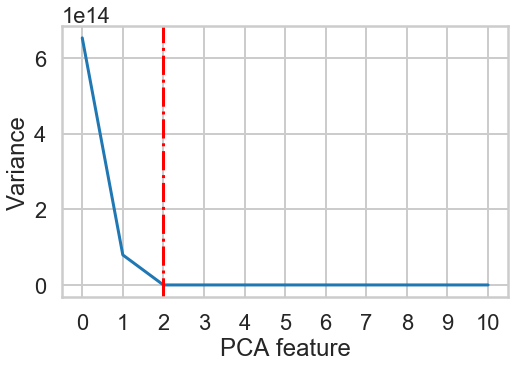

In [15]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)
features = range(pca.n_components_)

plt.rcParams["figure.figsize"] = (8,5)
plt.plot(features, pca.explained_variance_)
plt.axvline(x=2, c='red', linestyle = '-.')
plt.xticks(features)
plt.ylabel('Variance')
plt.xlabel('PCA feature')
plt.show()

In [16]:
#### normalize data
from sklearn import preprocessing
data_scaled = pd.DataFrame(preprocessing.scale(X),columns = X.columns) 

(pd.DataFrame(pca.components_.T, index=data_scaled.columns)).round(3).\
    rename(columns={0: 'pc-1', 1: 'pc-2', 2: 'pc-3', 3: 'pc-4'})[['pc-1', 'pc-2', 'pc-3', 'pc-4']]

/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


,pc-1,pc-2,pc-3,pc-4
creation_time,-0.687,-0.727,-0.000,0.000
last_session_creation_time,-0.727,0.687,-0.000,-0.000
opted_in_to_mailing_list,-0.000,0.000,0.000,0.000
enabled_for_marketing_drip,0.000,0.000,-0.000,0.000
org_id,-0.000,0.000,-0.002,1.000
invited_by_user_id,-0.000,-0.000,1.000,0.002
ORG_INVITE,-0.000,-0.000,0.000,-0.000
SIGNUP,0.000,0.000,-0.000,-0.000
GUEST_INVITE,0.000,0.000,-0.000,0.000
SIGNUP_GOOGLE_AUTH,0.000,0.000,-0.000,-0.000


Based on the PCA analysis, it looks like have two principle components is the most optimal in order for the model to predict most accurately. Based on the table above, the two primary features recommended for the primary components are "creation_time" and "last_session_creation_time." These features make sense when it comes to predicting future user adoption because the last session is one of the main indicators for what defines an "adopted user."

## Verify the primary features recommended by PCA using Logistic Regression

In [17]:
featurenames = ['creation_time', 'last_session_creation_time']
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           df_adopted_users_logreg, featurenames,
                                                           'is_adopted_user',1)

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.97
Accuracy on test data:     0.98


Re-performing the Logistic Regression model with the features determined through PCA, I got similar accuracy scores which confirms that the features that I selected based on PCA are the optimal features to determine whether a user will be "adopted."